### В ходе работы мы подготовим датасет, попробуем несколько видов кластеризации и оценим её качество.

In [1]:
# импортируем библиотеки для работы с данными
import pandas as pd
from sklearn import preprocessing 

# загрузим данные
df = pd.read_csv("data/segmented_customers.csv")
# посмотрим на данные
df.head()

,customer_id,gender,age,annual_income,spending_score
0,1,1,19.0,15.0,39.0
1,2,1,21.0,15.0,81.0
2,3,0,20.0,16.0,6.0
3,4,0,23.0,16.0,77.0
4,5,0,31.0,17.0,40.0


In [2]:
# В дата сете не поменяли пол, меняю сам что бы было как в юните.
df.gender = df.gender.apply(lambda x:'Male' if x == 0 else 'Female')

Проведём предобработку данных: удалим пропуски и дубли, признак Gender превратим в бинарный с помощью LabelEncoder:
Уже обработан дата фрейм, делаем только LabelEncoder

In [3]:
# переименуем столбцы для более удобной работы
df.rename(columns = {'CustomerID' : 'customer_id', 'Gender' : 'gender', 
                    'Age': 'age', 'Annual Income (k$)': 'annual_income', 
                    'Spending Score (1-100)': 'spending_score', }, inplace = True)

In [4]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df['gender'] = labelencoder.fit_transform(df['gender'])

In [5]:
df.tail()

,customer_id,gender,age,annual_income,spending_score
195,196,1,35.0,120.0,79.0
196,197,1,45.0,126.0,28.0
197,198,0,32.0,126.0,74.0
198,199,0,32.0,137.0,18.0
199,200,0,30.0,137.0,83.0


In [6]:
# проверим, есть ли в данных дубликаты
df[df.duplicated(subset=['customer_id'])]

,customer_id,gender,age,annual_income,spending_score


Чтобы мы могли визуально оценивать результаты кластеризации, будем проводить её по трём признакам, а именно: годовой заработок, коэффициент покупательской способности и возраст. Визуализируем распределение данных:

In [7]:
import plotly
import plotly.express as px

# передаём датафрейм и поля, которые нужно использовать для осей абсцисс, ординат и аппликат
fig = px.scatter_3d(
    data_frame=df, 
    x = 'age', 
    y = 'annual_income', 
    z = 'spending_score', 
    width=1000,
    height=700
)

#отображаем график
fig.show()

In [9]:
def get_3d_visualization(df, clust_res):
    fig = px.scatter_3d(
        data_frame=df, 
        x = 'age', 
        y = 'annual_income', 
        z = 'spending_score', 
        color = clust_res,
        width=1000,
        height=700
    )

    #возвращаем график
    return fig

In [8]:
# Сохраним признаки, по которым будем проводить моделирование, в переменную X:

X = df[['age', 'annual_income', 'spending_score']]

# Как мы видим, данные разрежённые и неоднородные, а значит, применять DBSCAN будет сложно, нужно будет подбирать параметры для кластеризации.

Задание 10.1

Попробуйте провести DBSCAN-кластеризацию со значениями по умолчанию. Сколько кластеров у вас получилось?

In [10]:
from sklearn.cluster import DBSCAN
import seaborn as sns 

clustering = DBSCAN()

cluster_predict = clustering.fit_predict(X)
df['dbscan_res_def'] = cluster_predict

get_3d_visualization(df, 'dbscan_res_def')


Как видно, алгоритм плохо работает с настройками по умолчанию, поэтому попробуем изменить их.

Большая часть наших данных разрежённые, а чем больше разброс точек в датасете, тем большее значение радиуса вокруг точки (eps) нужно задавать. Так как данные разрежённые, попробуем увеличить значение eps до 11 и визуально оценим результат:

In [22]:
# импортируем DBSCAN-кластеризацию
from sklearn.cluster import DBSCAN

#запускаем кластеризацию на наших данных
dbscan = DBSCAN(eps=11, min_samples=7)
clustering_dbscan_res = dbscan.fit_predict(X)
df['dbscan_res_eps_11'] = clustering_dbscan_res

get_3d_visualization(df, 'dbscan_res_eps_11')

Проведём агломеративную кластеризацию, чтобы построить дендрограмму и по ней оценить количество кластеров, на которое можно разделить датасет. Напишем функцию, которая будет принимать количество кластеров и матрицу с признаками:

In [23]:
# импортируем алгомеративную кластеризацию из sklearn
from sklearn.cluster import AgglomerativeClustering

# напишем функцию, которая будет проводить алгомеративную кластеризацию
# на вход она будет принимать X — матрицу с признаками для кластеризации и n_clusters — количество кластеров,
# на выходе будет возвращать список с номерами кластеров
def get_aggl_clustering(X, n_clusters):
    # запустим агломеративную кластеризацию
    agglomerative_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    # обучим модель агломеративной кластеризации
    agglomerative_clustering.fit(X)
    # получим список c информацией, к какому кластеру относятся объекты
    aggl_prediction = agglomerative_clustering.labels_
    # вернём список с результатами
    return aggl_prediction

<Figure size 720x504 with 0 Axes>

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [5.0, 5.0, 20.0, 20.0],
  [45.0, 45.0, 55.0, 55.0],
  [65.0, 65.0, 75.0, 75.0],
  [50.0, 50.0, 70.0, 70.0],
  [35.0, 35.0, 60.0, 60.0],
  [105.0, 105.0, 115.0, 115.0],
  [95.0, 95.0, 110.0, 110.0],
  [85.0, 85.0, 102.5, 102.5],
  [47.5, 47.5, 93.75, 93.75],
  [145.0, 145.0, 155.0, 155.0],
  [135.0, 135.0, 150.0, 150.0],
  [125.0, 125.0, 142.5, 142.5],
  [165.0, 165.0, 175.0, 175.0],
  [185.0, 185.0, 195.0, 195.0],
  [170.0, 170.0, 190.0, 190.0],
  [133.75, 133.75, 180.0, 180.0],
  [70.625, 70.625, 156.875, 156.875],
  [12.5, 12.5, 113.75, 113.75],
  [215.0, 215.0, 225.0, 225.0],
  [205.0, 205.0, 220.0, 220.0],
  [235.0, 235.0, 245.0, 245.0],
  [265.0, 265.0, 275.0, 275.0],
  [255.0, 255.0, 270.0, 270.0],
  [240.0, 240.0, 262.5, 262.5],
  [212.5, 212.5, 251.25, 251.25],
  [295.0, 295.0, 305.0, 305.0],
  [285.0, 285.0, 300.0, 300.0],
  [315.0, 315.0, 325.0, 325.0],
  [345.0, 345.0, 355.0, 355.0],
  [335.0, 335.0, 350.0, 350.0],
  [320.0, 320.0, 342

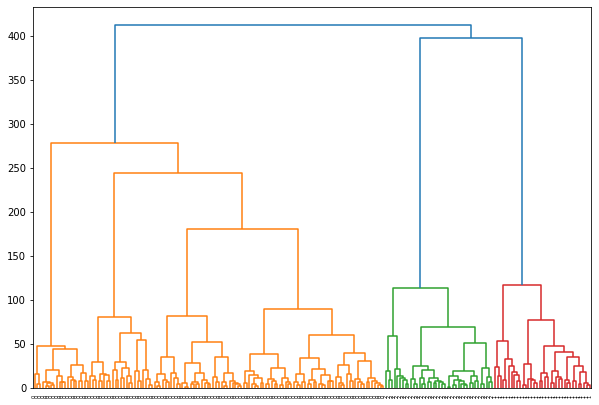

In [24]:
# импортируем библиотеку scipy, чтобы визуализировать дендрограмму
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

# запускаем агломеративную кластеризацию и сохраним результаты в df
df['aggl_res_3'] = get_aggl_clustering(X, 3)

linked = linkage(X, 'ward')
plt.figure(figsize=(10, 7))

dendrogram(linked,
            orientation='top',
            labels=df['aggl_res_3'].to_list(),
            distance_sort='descending',
            show_leaf_counts=True)

plt.show()

In [25]:
df['aggl_res_6'] = get_aggl_clustering(df[['age', 'annual_income', 'spending_score']], 6)
get_3d_visualization(df, 'aggl_res_6')

<AxesSubplot:xlabel='cluster', ylabel='silhouette'>

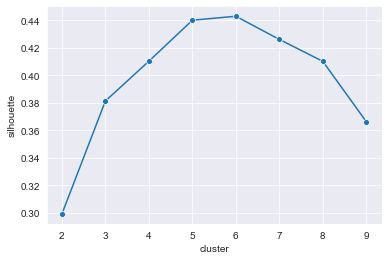

In [30]:
from sklearn.metrics import silhouette_score
import seaborn as sns

# напишем функцию для подсчёта коэффициента силуэта
def get_silhouette_agg_clust(X, cluster_num):
    # проведём агломеративную кластеризацию с заданным количеством кластеров
    res = get_aggl_clustering(X, cluster_num)
    # рассчитаем коэффициент силуэта
    silhouette = silhouette_score(X, res)
    return silhouette


# создадим пустой словарь, ключами будут коэффициент силуэта и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}


for cluster_num in range(2, 10):
    silhouette_res["silhouette"].append(get_silhouette_agg_clust(X, cluster_num))
    silhouette_res["cluster"].append(cluster_num)

# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

# установим стиль для визуализиции
sns.set_style("darkgrid")
# визуализируем зависимость значения инерции от количества кластеров
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker="o")

In [32]:
silhouette_df 

,silhouette,cluster
0,0.299259,2
1,0.381418,3
2,0.410380,4
3,0.440189,5
4,0.443089,6
5,0.426230,7
6,0.410284,8
7,0.366396,9


In [34]:
cluster = pd.read_csv('data/segmented_customers_cluster.csv')
cluster


,customer_id,gender,age,annual_income,spending_score,cluster
0,1,1,19.0,15.0,39.0,3
1,2,1,21.0,15.0,81.0,4
2,3,0,20.0,16.0,6.0,3
3,4,0,23.0,16.0,77.0,4
4,5,0,31.0,17.0,40.0,3
...,...,...,...,...,...,...
195,196,0,35.0,120.0,79.0,1
196,197,0,45.0,126.0,28.0,0
197,198,1,32.0,126.0,74.0,1
198,199,1,32.0,137.0,18.0,0


### <center> Лучьше уточнять в модуле!!!

In [38]:
# Метрику полноты можно вызвать из модуля cluster библиотеки sklearn. Метрика рассчитывается следующим образом:

from sklearn.metrics.cluster import completeness_score

print(completeness_score(labels_true=cluster.cluster, labels_pred=df.aggl_res_6))
# 0.9444702470046367
# Судя по значению метрики, кластеризация проведена отлично: кластеры получились наполненными элементами, а значит данные результаты можно дальше использовать для анализа.

0.9858363091910892
